In [1]:
# import package

# model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim
from torch.optim.lr_scheduler import StepLR

# dataset and transformation
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os

# display images
from torchvision import utils
import matplotlib.pyplot as plt
%matplotlib inline

# utils
import numpy as np
from torchsummary import summary
import time
import copy

In [2]:
# specify the data path
path2data = './archive/Training_Crop_Aug'

# if not exists the path, make the directory
#if not os.path.exists(path2data):
#    os.mkdir(path2data)

# load dataset
train_data = datasets.ImageFolder('.\\archive\\Training_Crop_Aug\\',  transform = transforms.ToTensor())

test_data = datasets.ImageFolder('.\\archive\\Testing_Crop\\',  transform = transforms.ToTensor())

print(len(train_data))
print(len(test_data))

5740
394


In [3]:
# To normalize the dataset, calculate the mean and std
train_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in train_data]
train_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in train_data]

train_meanR = np.mean([m[0] for m in train_meanRGB])
train_meanG = np.mean([m[1] for m in train_meanRGB])
train_meanB = np.mean([m[2] for m in train_meanRGB])
train_stdR = np.mean([s[0] for s in train_stdRGB])
train_stdG = np.mean([s[1] for s in train_stdRGB])
train_stdB = np.mean([s[2] for s in train_stdRGB])


val_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in test_data]
val_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in test_data]

val_meanR = np.mean([m[0] for m in val_meanRGB])
val_meanG = np.mean([m[1] for m in val_meanRGB])
val_meanB = np.mean([m[2] for m in val_meanRGB])

val_stdR = np.mean([s[0] for s in val_stdRGB])
val_stdG = np.mean([s[1] for s in val_stdRGB])
val_stdB = np.mean([s[2] for s in val_stdRGB])

print(train_meanR, train_meanG, train_meanB)
print(val_meanR, val_meanG, val_meanB)

0.2500208 0.2500208 0.2500208
0.30771264 0.30771264 0.30771264


In [4]:
# define the image transformation
train_transformation = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.RandomRotation(0.2),
                        transforms.RandomHorizontalFlip(),
                        transforms.Resize((224,224)),
                        transforms.Normalize([train_meanR, train_meanG, train_meanB],[train_stdR, train_stdG, train_stdB])
])

test_transformation = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Resize((224,224)),
                        transforms.Normalize([train_meanR, train_meanG, train_meanB],[train_stdR, train_stdG, train_stdB]),
])

In [5]:
train_data = datasets.ImageFolder('.\\archive\\Training_Crop_Aug\\',  transform = train_transformation)

test_data = datasets.ImageFolder('.\\archive\\Testing_Crop\\',  transform = test_transformation)

# apply transforamtion
train_data.transform = train_transformation
test_data.transform = test_transformation

# create DataLoader
train_dl = DataLoader(train_data, batch_size=8, shuffle=True)
test_dl = DataLoader(test_data, batch_size=8, shuffle=True)

train_data

train_data_size = len(train_data)
test_data_size = len(test_data)


In [6]:
#checking the size of the datasets
train_data_size, test_data_size

(5740, 394)

In [7]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        # BatchNorm에 bias가 포함되어 있으므로, conv2d는 bias=False로 설정합니다.
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion),
        )

        # identity mapping, input과 output의 feature map size, filter 수가 동일한 경우 사용.
        self.shortcut = nn.Sequential()

        self.relu = nn.ReLU()

        # projection mapping using 1x1conv
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x


class BottleNeck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        self.relu = nn.ReLU()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels*BottleNeck.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels*BottleNeck.expansion)
            )
            
    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x

In [17]:
class ResNet(nn.Module):
    def __init__(self, block, num_block, num_classes=10, init_weights=True):
        super().__init__()

        self.in_channels=64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # weights inittialization
        if init_weights:
            self._initialize_weights()

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self,x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        x = self.conv3_x(output)
        x = self.conv4_x(x)
        x = self.conv5_x(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    # define weight initialization function
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

def resnet18():
    return ResNet(BasicBlock, [2,2,2,2])

def resnet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def resnet50():
    return ResNet(BottleNeck, [3,4,6,3])

def resnet101():
    return ResNet(BottleNeck, [3, 4, 23, 3])

def resnet152():
    return ResNet(BottleNeck, [3, 8, 36, 3])

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = resnet50().to(device)
x = torch.randn(3, 3, 224, 224).to(device)
output = model(x)
print(output.size())

torch.Size([3, 10])


In [19]:
summary(model, (3, 224, 224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

     BatchNorm2d-125          [-1, 256, 14, 14]             512
            ReLU-126          [-1, 256, 14, 14]               0
          Conv2d-127         [-1, 1024, 14, 14]         262,144
     BatchNorm2d-128         [-1, 1024, 14, 14]           2,048
            ReLU-129         [-1, 1024, 14, 14]               0
      BottleNeck-130         [-1, 1024, 14, 14]               0
          Conv2d-131          [-1, 256, 14, 14]         262,144
     BatchNorm2d-132          [-1, 256, 14, 14]             512
            ReLU-133          [-1, 256, 14, 14]               0
          Conv2d-134          [-1, 256, 14, 14]         589,824
     BatchNorm2d-135          [-1, 256, 14, 14]             512
            ReLU-136          [-1, 256, 14, 14]               0
          Conv2d-137         [-1, 1024, 14, 14]         262,144
     BatchNorm2d-138         [-1, 1024, 14, 14]           2,048
            ReLU-139         [-1, 1024, 14, 14]               0
      BottleNeck-140         [-1, 1024, 

In [20]:
#Intialize Criterion and Optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)


In [21]:
def train(model, loss_criterion, optimizer, epochs):
    start = time.time()           #시작 time 재기!
    history = []
    best_acc = 0.0                #Best Accuracy Value

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))

        #Model to Training Mode!
        model.train()

        #Initialize Loss and Accuracy
        train_loss = 0.0
        train_acc = 0.0 

        for i, (inputs, labels) in enumerate(train_dl):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            #Forward Pass
            outputs = model(inputs)

            #Loss Computation
            loss = loss_criterion(outputs, labels)

            #Back Propagation
            loss.backward()

            #Update the parameters
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

            #Computing the accuracy(다소 헷갈리는 파트, 다시 확인!!!)
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            train_acc += acc.item() * inputs.size(0)

            if i % 100 == 0 and i != 0:
                print("Batch Number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

        avg_train_loss = train_loss / train_data_size
        avg_train_acc = train_acc / train_data_size
        history.append([avg_train_loss, avg_train_acc])

        epoch_end = time.time()

        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, epoch_end-epoch_start))
        if best_acc < avg_train_acc:
            best_acc = avg_train_acc
            torch.save(model, 'tumor' + '_model_' + str(epoch))
    return model, history

In [22]:
num_epochs = 5
train_model, history = train(model, criterion, optimizer, num_epochs)

#Saving model
torch.save(history, 'tumor' + '_history.pt')

Epoch: 1/5
Batch Number: 100, Training: Loss: 1.1300, Accuracy: 0.5000
Batch Number: 200, Training: Loss: 1.5885, Accuracy: 0.5000
Batch Number: 300, Training: Loss: 1.2947, Accuracy: 0.1250
Batch Number: 400, Training: Loss: 1.5566, Accuracy: 0.2500
Batch Number: 500, Training: Loss: 1.9536, Accuracy: 0.0000
Batch Number: 600, Training: Loss: 1.3063, Accuracy: 0.3750
Batch Number: 700, Training: Loss: 1.0631, Accuracy: 0.3750
Epoch : 000, Training: Loss: 1.3051, Accuracy: 36.6202%, Time: 167.5477s
Epoch: 2/5
Batch Number: 100, Training: Loss: 1.3791, Accuracy: 0.1250
Batch Number: 200, Training: Loss: 1.0708, Accuracy: 0.3750
Batch Number: 300, Training: Loss: 1.2081, Accuracy: 0.2500
Batch Number: 400, Training: Loss: 1.7432, Accuracy: 0.0000
Batch Number: 500, Training: Loss: 1.2070, Accuracy: 0.5000
Batch Number: 600, Training: Loss: 1.1248, Accuracy: 0.2500
Batch Number: 700, Training: Loss: 0.9256, Accuracy: 0.5000
Epoch : 001, Training: Loss: 1.2679, Accuracy: 38.0836%, Time: 16

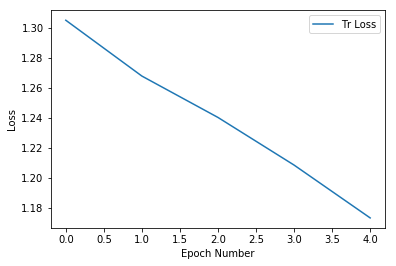

In [23]:
#Loss Examination Process
history = np.array(history)
plt.plot(history[:,0])
plt.legend(['Tr Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.savefig('tumor'+'_loss_curve.png')
plt.show()

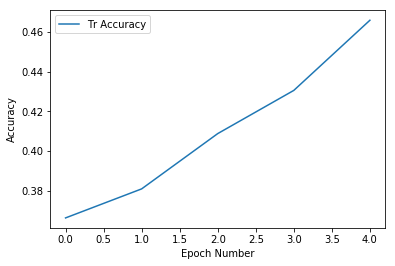

In [24]:
#Accuracy Examination Process
history = np.array(history)
plt.plot(history[:,1])
plt.legend(['Tr Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.savefig('tumor' + '_accuracy_curve.png')
plt.show()

In [25]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_dl:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Accuracy of the model on the test images: 29.695431472081218 %
